# Goal

This notebook is converted to .py for the purpose of training a **hybrid OBELISK-NET/UNET** segmentation model. A key concern is **memory usage**, i.e. tuning the batch size and presize HWD dimensions.

**Dataset**:
- Training Examples = 335:
- Input  = (MR series path, Segmentation obj path) in samir_labels (ABIDE dataset)
- Output = binary mask representing the sella turcica ROI.

**Augmentations**:
- Resize to 3mm isotropic
- Smooth inputs

**To Do**:
- TODO Augmentations: flip, orientation
- TODO Intensity normalization: N4 bias correction, hist bin matching, tissue intensity,

**With gratitude to**:
- https://github.com/mattiaspaul/OBELISK
-  https://github.com/kbressem/faimed3d/blob/main/examples/3d_segmentation.md

# Imports

In [1]:
# imports

# Utilities
import os
import time
import pickle
from pathlib import Path

# Fastai + PyTorch
from fastai import *
from torchvision.models.video import r3d_18
from fastai.callback.all import SaveModelCallback
from torch import nn

# 3D extension to FastAI
from faimed3d.all import *

# Input IO
import SimpleITK as sitk
import meshio

# Numpy and Pandas
import numpy as np
import pandas as pd
from pandas import DataFrame as DF

# Helper functions
from helpers_preprocess import get_data_dict, paths2objs, folder2objs, seg2mask, mask2bbox, print_bbox, get_bbox_size, print_bbox_size
from helpers_general import sitk2np, np2sitk, print_sitk_info, round_tuple, lrange, lmap, get_roi_range, numbers2groups
from helpers_viz import viz_axis

# GPU Stats

In [7]:
# clear cache
import gc
import torch

gc.collect()
torch.cuda.empty_cache()

# print GPU stats
import GPUtil as GPU
GPUs = GPU.getGPUs()
for gpu in GPUs:
    print("GPU {0:20s} RAM Free: {1:.0f}MB | Used: {2:.0f}MB | Util {3:3.0f}% | Total {4:.0f}MB".format(gpu.name, gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

GPU GeForce GTX 1080 Ti  RAM Free: 9450MB | Used: 1728MB | Util  15% | Total 11178MB
GPU GeForce GTX 1080     RAM Free: 7948MB | Used: 168MB | Util   2% | Total 8116MB


# Distributed Training

In [27]:
# from fastai.distributed import *
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument("--local_rank", type=int)
# args = parser.parse_args()
# torch.cuda.set_device(args.local_rank)
# torch.distributed.init_process_group(backend='nccl', init_method='env://')

# Data

1. Set source = path to where labelled data is stored (on HD, etc)
2. Load items into dictionary:
    - key = foldername
    - value = (path to MR series, path to Segmentation obj)
    
Special subsets:
1. *training*: small subset of all labelled items (quick epoch w/ 100 instead of 335 items).
2. *unique*: subset of items with unique size, spacing, and orientation (quickly evaluate resize vs. istropic)

In [37]:
subset_size = 335
bs          = 2
maxs        = [87, 90, 90]

In [49]:
# Get path to my data on 4 TB HD
hd  = "../" * 5 + "/media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a"
src = hd + "/home/rachel/PitMRdata"

# labelled train data
train_src = src + "/samir_labels"

# print
print("Folders in source path: ", end=""); print(*os.listdir(src), sep=", ")
print("Folders in train path: ", end=""); print(*os.listdir(train_src), sep=", ")

# get data
data = {}
folders = os.listdir(train_src)
for folder in folders: data.update(get_data_dict(f"{train_src}/{folder}"))

# all items
items = list(data.values())

# subset
rand_idx = torch.randperm(subset_size)
subset = np.array(items)[rand_idx]

# MR files: unique sz, sp, dir
with open('unique_sz_sp_dir.pkl', 'rb') as f:
    unique = pickle.load(f)

# Create (MR path, Segm path) item from MR path
def get_folder_name(s):
    s = s[len("../../../../..//media/labcomputer/e33f6fe0-5ede-4be4-b1f2-5168b7903c7a/home/rachel/PitMRdata/samir_labels/50155-50212/"):]
    return s[0:s.index("/")]

unique = [(mr, data[get_folder_name(mr)][1]) for mr in unique]

# print
print(f"Total {len(items)} items in dataset.")
print(f"Training subset of {len(subset)} items.")
print(f"Unique subset of {len(unique)} items.")

Folders in source path: ABIDE, PPMI, ABVIB, samir_labels
Folders in train path: 50155-50212, 50373-50453, 50002-50153, 50213-50312, 50313-50372
Total 335 items in dataset.
Training subset of 50 items.
Unique subset of 28 items.


# Transforms

1. Isotropic 3mm or Resize to 50x50x50 dimensions
2. Crop/Pad to common dimensions

In [51]:
class DoAll(ItemTransform):
    
    def __init__(self, new_sp = 3):
        self.new_sp = new_sp
        
    def encodes(self, x):
        # get sitk objs
        im_path, segm_path = x
        folder  = Path(segm_path).parent.name
        ras_adj = int(folder) in range(50455, 50464)

        mr         = sitk.ReadImage(im_path, sitk.sitkFloat32)
        segm       = meshio.read(segm_path)
        mask_arr   = seg2mask(mr, segm, ras_adj)

        # resize so isotropic spacing
        orig_sp = mr.GetSpacing()
        orig_sz = mr.GetSize()
        new_sz = [int(round(osz*ospc/self.new_sp)) for osz,ospc in zip(orig_sz, orig_sp)]

        im = torch.swapaxes(torch.tensor(sitk.GetArrayFromImage(mr)), 0, 2)
        mk = torch.tensor(mask_arr).float()

        while im.ndim < 5: 
            im = im.unsqueeze(0)
            mk = mk.unsqueeze(0)

        return F.interpolate(im, size = new_sz, mode = 'trilinear', align_corners=False).squeeze(), \
                F.interpolate(mk, size = new_sz, mode = 'nearest').squeeze().long()


# Crop

In [71]:
# crop by coords
class PadResize(Transform):
    def __init__(self, new_sz):
        self.new_sz = new_sz
    
    def encodes(self, arr):
        pad = [x-y for x,y in zip(self.new_sz, arr.shape)]
        pad = [a for amt in pad for a in (amt//2, amt-amt//2)]
        pad.reverse()
        
        return F.pad(arr, pad, mode='constant', value=0)

# Dataloaders

TODO augmentations.

- dset = tfms applied to items
- splits into training/valid
- bs

In [76]:
# time it
start = time.time()

# splits
splits = RandomSplitter(seed=42)(subset)
print(f"Training: {len(splits[0])}, Valid: {len(splits[1])}")

# tfms
tfms = [DoAll(3), PadResize(maxs)]

# tls
tls = TfmdLists(items, tfms, splits=splits)

# dls
dls = tls.dataloaders(bs=bs, after_batch=AddChannel())

# GPU
dls = dls.cuda()

# end timer
elapsed = time.time() - start
print(f"Elapsed time: {elapsed} s for {len(subset)} items")

# test get one batch
b = dls.one_batch()
print(type(b), b[0].shape, b[1].shape)
print(len(dls.train), len(dls.valid))

Training: 40, Valid: 10
Elapsed time: 3.726414203643799 s for 50 items
<class 'tuple'> torch.Size([2, 1, 87, 90, 90]) torch.Size([2, 1, 87, 90, 90])
20 5


# Metric

Linear combination of Dice and Cross Entropy

In [77]:
def dice(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return ((2. * intersection) /
           (iflat.sum() + tflat.sum()))

def dice_score(input, target):
    return dice(input.argmax(1), target)

def dice_loss(input, target): 
    return 1 - dice(input.softmax(1)[:, 1], target)

def loss(input, target):
    return dice_loss(input, target) + nn.CrossEntropyLoss()(input, target[:, 0])

In [78]:
# ipython nbconvert --to python  '6 - Dataloaders- NB - Simple-Copy1.ipynb'

# Learner

In [79]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [81]:
# OBELISK-NET from github
import sys
sys.path.append('/home/labcomputer/Desktop/Rachel/OBELISK')
from models import obelisk_visceral, obeliskhybrid_visceral

In [82]:
full_res = maxs

learn = Learner(dls=dls, \
                model=obeliskhybrid_visceral(num_labels=2, full_res=full_res), \
                loss_func= DiceLoss(), #nn.CrossEntropyLoss(), \
                metrics = dice_score, \
                model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')])

# SaveModelCallback: model_dir = "./models", cbs = [SaveModelCallback(monitor='dice_score')]
# GPU
learn.model = learn.model.cuda()

In [83]:
# test:

#dls.device = "cpu"

start = time.time()

x,y = dls.one_batch()
#x,y = to_cpu(x), to_cpu(y)

pred = learn.model(x)
loss = learn.loss_func(pred, y)

elapsed = time.time() - start

print(f"Elapsed: {elapsed} s")
print("Batch: x,y")
print(type(x), x.shape, x.dtype, "\n", type(y), y.shape, y.dtype)

print("Pred shape")
print(type(pred), pred.shape, pred.dtype)

print("Loss")
print(loss)
print(learn.loss_func)

Elapsed: 2.3611998558044434 s
Batch: x,y
<class 'torch.Tensor'> torch.Size([2, 1, 87, 90, 90]) torch.float32 
 <class 'torch.Tensor'> torch.Size([2, 1, 87, 90, 90]) torch.int64
Pred shape
<class 'torch.Tensor'> torch.Size([2, 2, 87, 90, 90]) torch.float32
Loss
tensor(0.6130, device='cuda:0', grad_fn=<MeanBackward0>)


# LR Finder

SuggestedLRs(lr_min=0.33113112449646, lr_steep=0.2089296132326126)

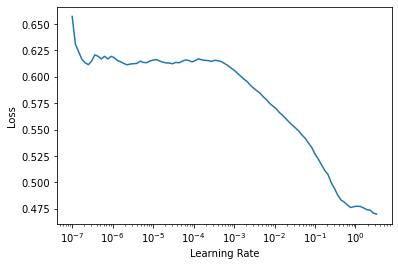

In [236]:
#learn.lr_find()

In [84]:
print("PRE learn.fit one cycle")
learn.fit_one_cycle(1, 3e-3, wd = 1e-4)

PRE learn.fit one cycle


epoch,train_loss,valid_loss,dice_score,time
0,0.549672,0.525197,0.000011,00:21


In [ ]:
print("unfreeze, learn 50")
learn.unfreeze()
learn.fit_one_cycle(50, 3e-3, wd = 1e-4)

unfreeze, learn 50


epoch,train_loss,valid_loss,dice_score,time
0,0.523237,0.524154,0.000000,00:22
1,0.519066,0.515394,0.051301,00:21
2,0.512814,0.504438,0.281212,00:22
3,0.503377,0.474921,0.317579,00:22
4,0.487377,0.466531,0.549518,00:22
5,0.432798,0.351891,0.384947,00:22
6,0.350555,0.318169,0.345447,00:22
7,0.292465,0.336698,0.250133,00:21
8,0.241850,0.321447,0.333762,00:21
9,0.221463,0.307317,0.331379,00:22


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=6.309573450380412e-07)

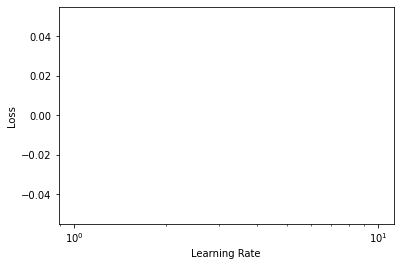

In [72]:
# learn.lr_find()